# CS440/ECE448 Spring 2024
# MP11: Policy Gradient Methods

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  It has the following content:

- `submitted.py`: Your homework. Edit, and then submit to Gradescope.
- `mp11_notebook.ipynb`: This is a Jupyter notebook to help you debug. You can completely ignore it if you want, although you might find that it gives you useful instructions.
- `grade.py`: Once your homework seems to be working, you can test it by typing python grade.py, which will run the tests in `tests/tests_visible.py`.
- `tests/test_visible.py`: This file contains about half of the unit tests that Gradescope will run in order to grade your homework. If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
- `solution.json`: This file contains the solutions for the visible test cases, in JSON format. If the instructions are confusing you, please look at this file, to see if it can help to clear up your confusion.
- `utils.py`: This is an auxiliary program that contains the simple evaluation environments and some helper code.

### Table of Contents

1. <a href="#intro">Introduction to Policy Gradient</a>
1. <a href="#return">Trajectory Return</a>
1. <a href="#vpg">Vanilla Policy Gradient</a>
1. <a href="#training">Policy Training</a>
1. <a href="#advantage">Advantage Estimation</a>
1. <a href="#ppo">Extra Credit: Proximal Policy Optimization</a>

In [1]:
# Initial imports
import importlib
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt
import utils
import submitted

<a id='intro'></a>
### Introduction

In this MP, we will introduce and implement policy gradient methods in reinforcement learning, specifically, a variant of [Proximal Policy Optimization](https://arxiv.org/pdf/1707.06347.pdf), or PPO. If you've heard of any impressive AI results where the policy "learns by itself", you have most likely heard of one that uses PPO as a component or basis! This includes [Deepmind's results in Starcraft](https://deepmind.google/discover/blog/alphastar-grandmaster-level-in-starcraft-ii-using-multi-agent-reinforcement-learning/) and [OpenAI's results in Dota 2](https://openai.com/research/openai-five-defeats-dota-2-world-champions), along with many results in robotics, self-driving, etc. Even [large language models such as Llama 2](https://arxiv.org/pdf/2307.09288.pdf) have used PPO as a human-feedback fine-tuning stage.

This is because PPO is one of the most robust reinforcement learning frameworks, while remaining simple to implement and scale.

PPO is a model-free reinforcement algorithm, and falls into the general class of *policy gradient* methods. These methods aim to maximize some kind of total expected return

$$J(\theta) = E_{\tau\sim\pi_\theta}\left[R(\tau)\right] = E_{\tau\sim\pi_\theta}\left[\sum_{t=0}^{T-1}r_t\right]$$

for a policy $\pi_\theta$ that is parameterized by $\theta$, where $R(\tau)$ denotes the total return of the trajectory $\tau$. Note that the expectation samples trajectories $\tau$ from the policy. In policy gradient, the policy is *stochastic*, and as such no special exploration provisions are required (although they can help, to tune exploration-exploitation tradeoff).

Intuitively, what we want to do is to find the "direction" to push $\theta$ that results in a larger $E[R(\pi_\theta)]$. This is the gradient of $J(\theta)$ with respect to $\theta$, or $\nabla_\theta J(\theta)$

We this value in terms of things we know, which we can achieve by some manipulation:

$$
\begin{align}
\nabla_\theta J(\theta) &= \nabla_\theta E_{\tau\sim\pi_\theta}\left[R(\tau)\right] & \\
&= \nabla_\theta \int_{\tau}P(\tau|\theta)R(\tau) & \Tiny\text{Expand expectation. An expectation is just integration over probability times outcome}\\
&= \int_{\tau}\nabla_\theta P(\tau|\theta)R(\tau) & \Tiny\text{Integration does not involve $\theta$, so $\nabla_\theta$ can be moved in}\\
&= \int_{\tau}P(\tau|\theta) \nabla_\theta \left(\log \left(P(\tau|\theta)\right) R(\tau)\right) & \Tiny\text{Since $\nabla_\theta \log f(\theta) = 1/f(\theta) \cdot \nabla_\theta f(\theta)$, with $f$ being $P(\tau|\theta)$ here}\\
&= E_{\tau\sim\pi_\theta}\left[\nabla_\theta \left(\log \left(P(\tau|\theta)\right) R(\tau)\right)\right] & \Tiny\text{Again, $\int_{\tau}P(\tau|\theta)$ is equivalent to expectation}\\
&= E_{\tau\sim\pi_\theta}\left[\nabla_\theta \left(\log \left(\prod_{T}^{t=0}\pi_\theta(a_t|s_t)\right) R(\tau)\right)\right] & \Tiny\text{Probability of the whole trajectory is product of each state-action pair}\\
&= E_{\tau\sim\pi_\theta}\left[\nabla_\theta \left(\sum_{t=0}^T\log(\pi_\theta(a_t | s_t)) R(\tau))\right) \right] &\Tiny\text{Product inside log is sum outside}\\
&= E_{\tau\sim\pi_\theta}\left[\sum_{t=0}^T\nabla_\theta \log(\pi_\theta(a_t | s_t)) R(\tau)) \right] &\Tiny\text{Sum does not involve $\theta$, so gradient can be brought inside}
\end{align}
$$

This leaves us with an expression that depends on:
* $\nabla_\theta \log(\pi_\theta(a_t | s_t))$, the gradient of the policy for a state-action pair
* $R(\tau)$, the trajectory return

We will deal with the trajectory return first.

<a id='return'></a>
### Trajectory Return

Reinforcement learning is generally specified in terms of rewards, which are summed over time into returns. Oftentimes an discount factor is used, so the return does not go to infinity. This discount factor is between 0 and 1, and is multipiled to the accumulated return at every timestep. That is,

$$R(\tau) = r_0 + \gamma \cdot \left(r_1 + \gamma \cdot \left(\cdots\right)\right) = \sum_{i=0}^T r_i \cdot \gamma^{i}$$

Note that the policy has no effect on returns that *already happened*. This means that what we really really care about is the component of $R(\tau)$ that exists after $t$. As such, we modify the return into a *future return* that gets rid of all $r_t$ before the current time.

That is, given a sequence of rewards $r_0 \cdots r_T$, the future return at time $t$ is:
$$R_t(\tau) = \sum_{i=t}^T r_i \cdot \gamma^{i-t}$$
instead.

Implement getting this future return in `get_returns`. Note that the rewards are provided inside a container `rollout_buffer`, and can be accessed as `rollout_buffer.rewards`. Hint: this is significantly easier to do accessing the rollout buffer in reverse.

In [2]:
import utils
rollout_buffer = utils.RolloutBuffer()
# Add two episodes to the rollout buffer where the rewards go 1, 2, 3, 4....
dummy = torch.tensor([0])
for _ in range(2):
    for i in range(10):
        rollout_buffer.add(action=dummy, logits=dummy, observation=dummy, terminated=False, reward=i)
    rollout_buffer.add(action=dummy, logits=dummy, observation=dummy, terminated=True, reward=10)
rollout_buffer.finalize()

import submitted
importlib.reload(submitted)

# Note the two distinct rollouts visible in the returns
submitted.get_returns(rollout_buffer, discount_factor=0.5)

tensor([[ 1.9883],
        [ 3.9766],
        [ 5.9531],
        [ 7.9062],
        [ 9.8125],
        [11.6250],
        [13.2500],
        [14.5000],
        [15.0000],
        [14.0000],
        [10.0000],
        [ 1.9883],
        [ 3.9766],
        [ 5.9531],
        [ 7.9062],
        [ 9.8125],
        [11.6250],
        [13.2500],
        [14.5000],
        [15.0000],
        [14.0000],
        [10.0000]])

<a id='vpg'></a>
### Vanilla Policy Gradient

Now, let's implement the vanilla policy gradient. For the sake of implementation, we make a few changes to the original formulation:

First, the true expected value is impossible to find. Instead, we take a Monte Carlo estimate of it. That is, we sample a couple trajectories $\tau_0 \cdots \tau_n$, then just take the mean over those trajectories.<a name="cite_ref-1"></a>[<sup>$\dagger$</sup>](#cite_note-1)

Along with using future return instead, this means our expression is now

$$
\nabla_\theta J(\theta) = \nabla_\theta \frac{1}{n}\sum_{\tau = \tau_0 \cdots \tau_n} \left[\sum_{t=0}^T\log(\pi_\theta(a_t | s_t)) R_t(\tau)) \right]
$$

Since we are using autograd, the expression we want is just $J(\theta)$, and torch will take care of the gradient for us. Also, since we will be minimizing this loss, the returned value should be $-J(\theta)$

That is, the implemented function `get_vanilla_policy_gradient_loss` should return a scalar:
$$
-J(\theta) = -\frac{1}{n}\sum_{\tau = \tau_0 \cdots \tau_n} \left[\sum_{t=0}^T\log(\pi_\theta(a_t | s_t)) R_t(\tau)) \right]
$$


Implement this. As a hint, `policy` will output a `batch x action_dim` tensor when called with `observation`. This tensor is structured as:

$$
\begin{bmatrix}
\log(\pi_\theta(a_0 | s_0)) & \log(\pi_\theta(a_1 | s_0)) & \cdots & \log(\pi_\theta(a_{d_a} | s_0))\\
\vdots & \vdots & \ddots & \vdots\\
\log(\pi_\theta(a_0 | s_{d_b})) & \log(\pi_\theta(a_1 | s_{d_b})) & \cdots & \log(\pi_\theta(a_{d_a} | s_{d_b}))\\
\end{bmatrix}
$$

where $d_b$ denotes the batch size and $d_a$ denotes the action dimension.

Make sure you use torch functions only to preserve the gradient! If you convert the torch tensors to numpy, this gradient will be lost. Also note that the policy we provide outputs logits, that is, calling `policy.forward` will give you $\log(\pi_\theta(a_t | s_t))$. This is a common practice in deep learning for numeric stability.

<a name="cite_note-1"></a>[$\dagger$](#cite_ref-1) <sup>Strictly speaking, the $\nabla_\theta J(\theta)$ we had\-before is actually only an expectation over the policy, and $\tau$ is still a random variable with randomness from the environment, if the environment is stochastic. When we take a Monte Carlo estimate, we also end up marginalizing $\tau$ over any randomness in the environment</sup>

In [3]:
obs_space_sz = 3
act_space_sz = 2
batch_sz = 4

policy = utils.SimpleReLuNetwork(obs_space_sz, act_space_sz,
                                 out_logsoftmax=True, fixed_init=[0.5, 0.5])

importlib.reload(submitted)

torch.manual_seed(0)
submitted.get_vanilla_policy_gradient_loss(
    policy=policy,
    observation         = torch.rand((4, obs_space_sz)),
    action              = torch.randint(low=0, high=act_space_sz, size=(4, 1)),
    return_or_advantage = torch.rand((4, 1)),
)

# For your sanity checking. This should spit out a size 1 tensor with value 0.3363

tensor(0.3363, grad_fn=<DivBackward0>)

<a id='training'></a>
### Policy Training

Finally, implement policy training in `train_policy_gradient`. This has been mostly filled out for you, however you will need to add some code to collect rollouts, as well as fill out the policy gradient arguments dictionary. This should be relatively straightforward.

Please use the provided line `action = utils.distribution_sample(logits, seed=seed)` to sample from the logits. This is important for the autograder. Also, note that tests that involve advantages will not work yet, as they require components from later on.

We can now try training on an extremely simple environment, where the goal is to move from a randomly generated start point to a randomly generated target point within a line, where actions are to move +1, 0, and -1 (with no obstacles). You should see the reward increase. You may also see *catastrphic forgetting*, where the reward increases, then sharply drops off at some point during training. We will address this in a later step.

Note that the loss *does not necessarily decrease* for policy gradient -- this is normal! Even though the optimizer is optimizing for the loss, the policy is also exploring different areas of state-space, which makes interpreting the loss relatively complex.

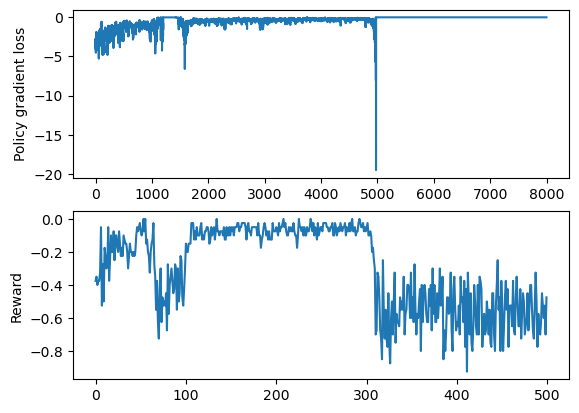

In [5]:
importlib.reload(submitted)

env = utils.GridWorldPointTargetEnv(grid_size=10, dimensions=1, episode_length=20)
actor = utils.SimpleReLuNetwork(2, 3, hidden_dims=[16], out_logsoftmax=True)
optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)
losses_actor, _, final_rewards, _ = submitted.train_policy_gradient(
    env=env,
    policy=actor, optimizer=optimizer,
    get_policy_gradient_loss=submitted.get_vanilla_policy_gradient_loss,
    get_returns=submitted.get_returns,
    critic_loss_multiplier = 0.01,
    rollouts=2_000,
    rollouts_before_training=4,
    training_epochs_per_rollout=8,
    minibatch_size=64
)

fig, axs = plt.subplots(2)
axs[0].plot(losses_actor)
axs[0].set_ylabel("Policy gradient loss")
axs[1].plot(final_rewards)
axs[1].set_ylabel("Reward")
plt.show()


We can also take a look at how well our trained policy does, and what it's doing

Collected 100 rollouts with mean reward -0.586
Success rate of 0%


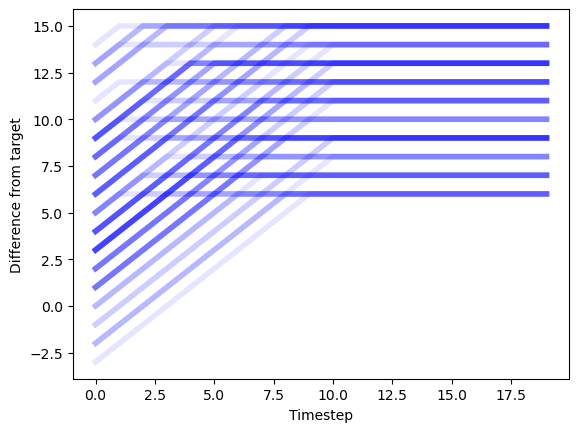

In [7]:
N_ROLLOUTS = 100
rollout_buffer, reward_mean = submitted.collect_rollouts(
        env=env, policy=actor, num_rollouts=N_ROLLOUTS)
print(f"Collected {N_ROLLOUTS} rollouts with mean reward {reward_mean}")

success_rate = utils.show_lineworld_rollouts(env, rollout_buffer)

print(f"Success rate of {success_rate * 100:.0f}%")

You should see lines converging to the center some degree, but it's pretty bad. Some runs may work fairly well, but overall performance is poor, even on an extremely simple environment. To fix this, we look into using the concept of **advantage**

<a id='advantage'></a>
### Advantage Estimation

Previously, the policy gradient was implemented using future returns:
$$R_t(\tau) = \sum_{i=t}^T r_i \cdot \gamma^{i-t}$$
where $r_i$ is the return at time $i$. This works, but we can make an improvement by looking at *whether an action was better or worse than the average for the state* instead of looking at $r_i$ directly.

For some intuition, consider some particular state where the return is consistently high, but with some variation between actions. Then, the policy gradient will be "pushing" the policy only slightly differently for the different actions, and what we actually care about is the *difference* between these pushes to get the best action. The rest of the return doesn't tell us anything about what "direction" the policy should be shifted, so it's useless. In fact, it's worse than useless, since our policy gradient will vary greatly depending on whether we manage to visit this state or not. This means the variance of the policy gradient will be high, which destabilizes training and can cause catastrophic forgetting.<a name="cite_ref-1"></a>[<sup>$\dagger$</sup>](#cite_note-1)

To achieve this, we'll need an estimator of the mean future return at each state across all actions. Let's call this $V(s_t)$. We can obtain this by just training another neural network to estimate the return, given the observation. Implement a mean squared error loss to minimize error between $V(s_t)$ and $r_t$ in `get_value_net_loss`. The gradient descent process takes care of averaging over $a_t$ for us.

Then, we can calculate advantage as $A_t = (R_t - V_t(s_t))$, and replace $R_t$ with this in the policy gradient. Implement advantages in `get_advantages`. Make sure that in `train_policy_gradient`, you are providing `return_or_advantage` correctly, as sliced advantages.


<a name="cite_note-1"></a>[$\dagger$](#cite_ref-1) <sup>This is a very handwavey explanation -- if you are interested in the mathmatical explanation, [here is one attempted somewhat simple more rigorous explanation](https://kjabon.github.io/blog/2023/Baseline/), and here is the [original paper for generalized advantage estimation](https://arxiv.org/pdf/1506.02438.pdf)

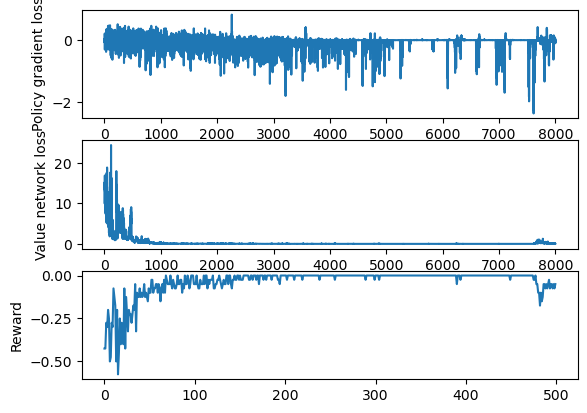

In [8]:
importlib.reload(submitted)

env = utils.GridWorldPointTargetEnv(grid_size=10, dimensions=1, episode_length=20)
actor = utils.SimpleReLuNetwork(2, 3, hidden_dims=[16], out_logsoftmax=True)
critic = utils.SimpleReLuNetwork(2, 1, hidden_dims=[16])
optimizer = torch.optim.Adam(itertools.chain(actor.parameters(), critic.parameters()), lr=1e-3)
losses_actor, losses_critic, final_rewards, lr = submitted.train_policy_gradient(
    env=env,
    policy=actor, optimizer=optimizer,
    get_policy_gradient_loss=submitted.get_vanilla_policy_gradient_loss,
    get_returns=submitted.get_returns,
    value_net=critic,
    get_advantages = submitted.get_advantages,
    get_value_net_loss = submitted.get_value_net_loss,
    critic_loss_multiplier = 0.01,
    rollouts=2_000,
    rollouts_before_training=4,
    training_epochs_per_rollout=8,
    minibatch_size=64
)

fig, axs = plt.subplots(3)
axs[0].plot(losses_actor)
axs[0].set_ylabel("Policy gradient loss")
axs[1].plot(losses_critic)
axs[1].set_ylabel("Value network loss")
axs[2].plot(final_rewards)
axs[2].set_ylabel("Reward")
plt.show()


Collected 100 rollouts with mean reward -0.041999999999999996
Success rate of 58%


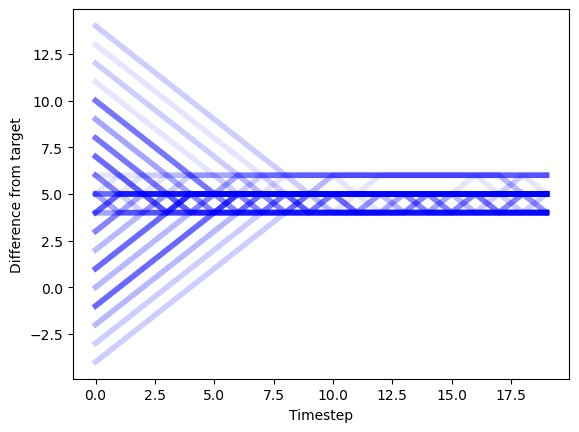

In [9]:
N_ROLLOUTS = 100
rollout_buffer, reward_mean = submitted.collect_rollouts(
        env=env, policy=actor, num_rollouts=N_ROLLOUTS)
print(f"Collected {N_ROLLOUTS} rollouts with mean reward {reward_mean}")

success_rate = utils.show_lineworld_rollouts(env, rollout_buffer)

print(f"Success rate of {success_rate * 100:.0f}%")

This should be much better. You can also try running this on a more complicated double pendulum swingup environment from OpenAI Gym.

Note: You will need to install `gymnasium-0.29.1`. This section is purely for fun and is optional. Training will take an extremely long time (upwards of an hour if training on CPU)

In [10]:
importlib.reload(utils)

env = utils.OpenAIGymEnv()
actor = utils.SimpleReLuNetwork(4, 2, hidden_dims=[300, 400], out_logsoftmax=True)
critic = utils.SimpleReLuNetwork(4, 1, hidden_dims=[300, 400])
optimizer = torch.optim.Adam(itertools.chain(actor.parameters(), critic.parameters()), lr=1e-6)
losses_actor, losses_critic, final_rewards, lr = submitted.train_policy_gradient(
    env=env,
    policy=actor, optimizer=optimizer,
    get_policy_gradient_loss=submitted.get_vanilla_policy_gradient_loss,
    get_returns=submitted.get_returns,
    value_net=critic,
    get_advantages = submitted.get_advantages,
    get_value_net_loss = submitted.get_value_net_loss,
    critic_loss_multiplier = 1.0,
    rollouts=20_000,
    rollouts_before_training=64,
    training_epochs_per_rollout=8,
    minibatch_size=1024
)

fig, axs = plt.subplots(3)
axs[0].plot(losses_actor)
axs[0].set_ylabel("Policy gradient loss")
axs[1].plot(losses_critic)
axs[1].set_ylabel("Value network loss")
axs[2].plot(final_rewards)
axs[2].set_ylabel("Reward")
plt.show()


ModuleNotFoundError: No module named 'gymnasium'

In [11]:
# This will open a PyGame window
N_ROLLOUTS = 10
rollout_buffer, reward_mean = submitted.collect_rollouts(

env=utils.OpenAIGymEnv(vis=True), policy=actor, num_rollouts=N_ROLLOUTS)

ModuleNotFoundError: No module named 'gymnasium'

<a id='ppo'></a>
# Extra Credit: Proximal Policy Optimization

Vanilla policy gradient remains extremely fragile and sensitive to hyperparameters. For example, if the learning rate of the above success on the simple environment is increased to 4e-3 from 1e-3, performance plumments:

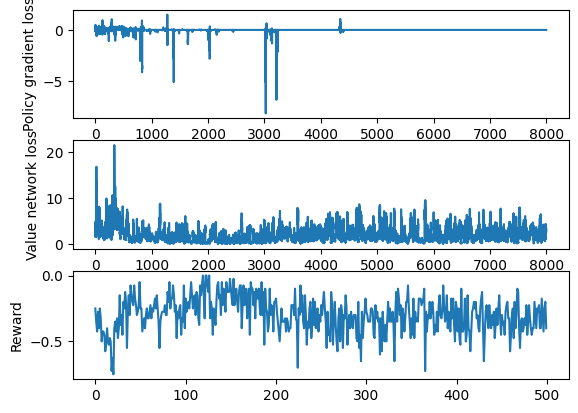

In [8]:
importlib.reload(submitted)

env = utils.GridWorldPointTargetEnv(grid_size=10, dimensions=1, episode_length=20)
actor = utils.SimpleReLuNetwork(2, 3, hidden_dims=[16], out_logsoftmax=True)
critic = utils.SimpleReLuNetwork(2, 1, hidden_dims=[16])
optimizer = torch.optim.Adam(itertools.chain(actor.parameters(), critic.parameters()), lr=4e-3)
losses_actor, losses_critic, final_rewards, lr = submitted.train_policy_gradient(
    env=env,
    policy=actor, optimizer=optimizer,
    get_policy_gradient_loss=submitted.get_vanilla_policy_gradient_loss,
    get_returns=submitted.get_returns,
    value_net=critic,
    get_advantages = submitted.get_advantages,
    get_value_net_loss = submitted.get_value_net_loss,
    critic_loss_multiplier = 0.01,
    rollouts=2_000,
    rollouts_before_training=4,
    training_epochs_per_rollout=8,
    minibatch_size=64
)

fig, axs = plt.subplots(3)
axs[0].plot(losses_actor)
axs[0].set_ylabel("Policy gradient loss")
axs[1].plot(losses_critic)
axs[1].set_ylabel("Value network loss")
axs[2].plot(final_rewards)
axs[2].set_ylabel("Reward")
plt.show()


Collected 100 rollouts with mean reward -0.31800000000000006
Success rate of 12%


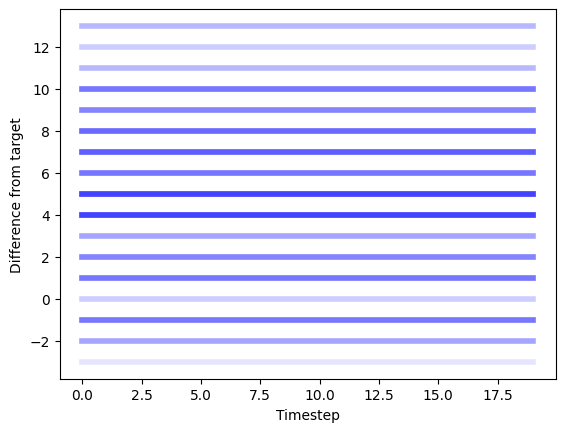

In [9]:
N_ROLLOUTS = 100
rollout_buffer, reward_mean = submitted.collect_rollouts(
        env=env, policy=actor, num_rollouts=N_ROLLOUTS)
print(f"Collected {N_ROLLOUTS} rollouts with mean reward {reward_mean}")

success_rate = utils.show_lineworld_rollouts(env, rollout_buffer)

print(f"Success rate of {success_rate * 100:.0f}%")

[Proximal policy optimization](https://arxiv.org/abs/1707.06347) combats this by constraining the loss, making sure updates are relatively small.

This is done by keeping around the old logits $\pi_{\theta_{old}}$, and calculating a ratio

$$
r_t(\theta) = \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}
$$

This ratio is 1 when the logits are equal, and diverges from 1 when they begin to diverge. Greater than 1 means the action is more likely in the new policy, and less than one means it is less likely.

When the advantage is positive, we want to stop the "pushing" on the policy at some point when the action is far more likely in the new policy, so the ratio should be upper-limited. Similarly, when the advantage is negative, the ratio is lower-limited.

Note that lower-limiting the ratio when the advantage is positive is not a good idea! If the new policy has ended up with a good action (positive advantage) significantly less likely than it used to be, we want a strong "push" to get it back in the right direction. The same applies to upper-limiting the ratio when the advantage is negative.

An expression that fulfills this purpose is:
$$
\min \left(r_t(\theta) A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t\right)
$$
Note that when A_t is positive, the minimum can only kick in on the $1+\epsilon$ bound, and vice-versa when A_t is negative.

Recall that the vanilla policy gradient loss is:

$$
-J(\theta) = -\frac{1}{n}\sum_{\tau = \tau_0 \cdots \tau_n} \left[\sum_{t=0}^T\log(\pi_\theta(a_t | s_t)) A_t) \right]
$$

Since we only really care about broad "push" directions, we look at replacing the $\log(\pi_\theta(a_t | s_t)) A_t$ term with the PPO expression from above -- both "trend" with $A_t$ and $\pi_\theta(a_t | s_t))$ the same way. This means the PPO policy gradient loss is:

$$
-J(\theta) = -\frac{1}{n}\sum_{\tau = \tau_0 \cdots \tau_n} \left[\sum_{t=0}^T\log(\pi_\theta(a_t | s_t)) A_t) \right]
$$

Implement this. Recall that `policy` outputs log probabilities, so you will need to take an exponent.

With this loss, increasing the learning rate (within reason) no longer causes issues.

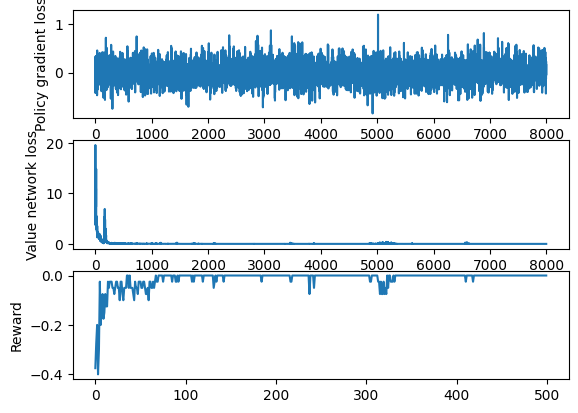

In [10]:
importlib.reload(submitted)

env = utils.GridWorldPointTargetEnv(grid_size=10, dimensions=1, episode_length=20)
actor = utils.SimpleReLuNetwork(2, 3, hidden_dims=[16], out_logsoftmax=True)
critic = utils.SimpleReLuNetwork(2, 1, hidden_dims=[16])
optimizer = torch.optim.Adam(itertools.chain(actor.parameters(), critic.parameters()), lr=4e-3)
losses_actor, losses_critic, final_rewards, lr = submitted.train_policy_gradient(
    env=env,
    policy=actor, optimizer=optimizer,
    get_policy_gradient_loss=submitted.get_PPO_policy_gradient_loss,
    get_returns=submitted.get_returns,
    value_net=critic,
    get_advantages = submitted.get_advantages,
    get_value_net_loss = submitted.get_value_net_loss,
    critic_loss_multiplier = 0.01,
    rollouts=2_000,
    rollouts_before_training=4,
    training_epochs_per_rollout=8,
    minibatch_size=64
)

fig, axs = plt.subplots(3)
axs[0].plot(losses_actor)
axs[0].set_ylabel("Policy gradient loss")
axs[1].plot(losses_critic)
axs[1].set_ylabel("Value network loss")
axs[2].plot(final_rewards)
axs[2].set_ylabel("Reward")
plt.show()


Collected 100 rollouts with mean reward 0.0
Success rate of 100%


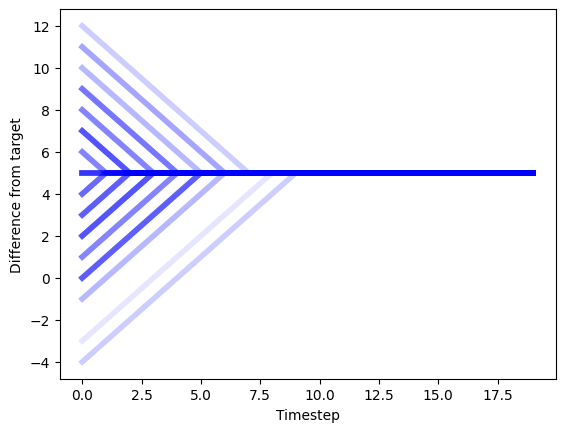

In [11]:
N_ROLLOUTS = 100
rollout_buffer, reward_mean = submitted.collect_rollouts(
        env=env, policy=actor, num_rollouts=N_ROLLOUTS)
print(f"Collected {N_ROLLOUTS} rollouts with mean reward {reward_mean}")

success_rate = utils.show_lineworld_rollouts(env, rollout_buffer)

print(f"Success rate of {success_rate * 100:.0f}%")